In [9]:
import numpy as np
import pandas as pd
import os.path as osp
import torch
from tqdm import tqdm
from joblib.parallel import Parallel, delayed
from matplotlib import pyplot as plt

from molecules.parse_sdf import get_num_atoms_from_smiles


In [2]:
SEED = 42
ROOT = "."
DATASET = osp.join(ROOT, "pcqm4m-v2-geometry-normed.csv.gz")
VAL_RATIO = 0.05
TEST_RATIO = 0.05
SHUFFLE_DIR = osp.join(ROOT, "shuffle_split_dict.pt")
NUMATOMS_DIR = osp.join(ROOT, "num_atoms_split_dict.pt")

In [3]:
smiles = pd.read_csv(DATASET, nrows=None, usecols=["smiles"])["smiles"]
smiles

0          O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C
1                  COc1cc(OC)ccc1/C=C/N(C(=O)C)C
2                    C=CCN(C(=O)C)/C=C/c1ccccc1C
3                    C=CCN(C(=O)C)/C=C/c1ccccc1F
4                   C=CCN(C(=O)C)/C=C/c1ccccc1Cl
                           ...                  
3378521    Cc1ccc(c(c1)C)N[C@H](/C(=N\C1CC1)/O)C
3378522     C[C@@H](/C(=N\C1CC1)/O)Nc1cccc(c1C)C
3378523     C[C@H](/C(=N\C(=N)O)/O)Nc1cccc(c1C)C
3378524    C[C@@H](/C(=N\C(=N)O)/O)Nc1cccc(c1C)C
3378525              CCOc1ccccc1NC/C(=N\C1CC1)/O
Name: smiles, Length: 3378526, dtype: object

In [4]:
num_atoms = Parallel(n_jobs=-1)(delayed(get_num_atoms_from_smiles)(s) for s in tqdm(smiles))

 50%|████▉     | 1674892/3378526 [00:15<00:15, 112748.03it/s][19:44:18] WARNING: not removing hydrogen atom without neighbors
[19:44:18] WARNING: not removing hydrogen atom without neighbors
[19:44:18] WARNING: not removing hydrogen atom without neighbors
[19:44:18] WARNING: not removing hydrogen atom without neighbors
[19:44:18] WARNING: not removing hydrogen atom without neighbors
[19:44:18] WARNING: not removing hydrogen atom without neighbors
 54%|█████▎    | 1808491/3378526 [00:16<00:15, 101366.30it/s][19:44:19] WARNING: not removing hydrogen atom without neighbors
[19:44:19] WARNING: not removing hydrogen atom without neighbors
[19:44:19] WARNING: not removing hydrogen atom without neighbors
[19:44:19] WARNING: not removing hydrogen atom without neighbors
 58%|█████▊    | 1943535/3378526 [00:17<00:12, 117184.34it/s][19:44:20] WARNING: not removing hydrogen atom without neighbors
[19:44:20] WARNING: not removing hydrogen atom without neighbors
[19:44:20] WARNING: not removing hydr

In [5]:
def create_shuffle_split(N, val_ratio, test_ratio):
    """ Create a random shuffle split and saves it to disk.
    Args:
        N: Total size of the dataset to split.
    """
    rng = np.random.default_rng(seed=SEED)
    all_ind = rng.permutation(N)
    train_ratio = 1 - val_ratio - test_ratio
    val_ratio_rem = val_ratio / (val_ratio + test_ratio)

    # Random shuffle split into 90/5/5.
    train_ind, tmp_ind = all_ind[:int(train_ratio * N)], all_ind[int(train_ratio * N):]
    val_ind = tmp_ind[:int(val_ratio_rem * len(tmp_ind))]
    test_ind = tmp_ind[int((1-val_ratio_rem) * len(tmp_ind)):]
    assert check_splits(N, [train_ind, val_ind, test_ind], [train_ratio, val_ratio, test_ratio])

    shuffle_split = {'train': train_ind, 'val': val_ind, 'test': test_ind}
    torch.save(shuffle_split, SHUFFLE_DIR)

def create_numatoms_split(num_atoms_list, val_ratio, test_ratio):
    """ Create split by the size of molecules, testing on the largest ones.
    Args:
        num_atoms_list: List with molecule size per each graph.
    """
    rng = np.random.default_rng(seed=SEED)
    all_ind = np.argsort(np.array(num_atoms_list))
    train_ratio = 1 - val_ratio - test_ratio
    val_ratio_rem = val_ratio / (val_ratio + test_ratio)

    # Split based on mol size into 90/5/5, but shuffle the top 10% randomly
    # before splitting to validation and test set.
    N = len(num_atoms_list)
    train_ind, tmp_ind = all_ind[:int(train_ratio * N)], all_ind[int(train_ratio * N):]
    rng.shuffle(tmp_ind)
    val_ind = tmp_ind[:int(val_ratio_rem * len(tmp_ind))]
    test_ind = tmp_ind[int((1-val_ratio_rem) * len(tmp_ind)):]
    assert len(train_ind) + len(val_ind) + len(test_ind) == N
    assert check_splits(N, [train_ind, val_ind, test_ind], [train_ratio, val_ratio, test_ratio])

    size_split = {'train': train_ind, 'val': val_ind, 'test': test_ind}
    torch.save(size_split, osp.join(ROOT, NUMATOMS_DIR))

def check_splits(N, splits, ratios):
    """ Check whether splits intersect and raise error if so.
    """
    assert sum([len(split) for split in splits]) == N
    for ii, split in enumerate(splits):
        true_ratio = len(split) / N
        assert abs(true_ratio - ratios[ii]) < 3/N
    for i in range(len(splits) - 1):
        for j in range(i + 1, len(splits)):
            n_intersect = len(set(splits[i]) & set(splits[j]))
            if n_intersect != 0:
                raise ValueError(
                    f"Splits must not have intersecting indices: "
                    f"split #{i} (n = {len(splits[i])}) and "
                    f"split #{j} (n = {len(splits[j])}) have "
                    f"{n_intersect} intersecting indices"
                )
    return True

In [6]:
create_numatoms_split(num_atoms, VAL_RATIO, TEST_RATIO)
create_shuffle_split(len(smiles), VAL_RATIO, TEST_RATIO)

In [7]:
num_atoms_split = torch.load(NUMATOMS_DIR)
shuffle_split = torch.load(SHUFFLE_DIR)

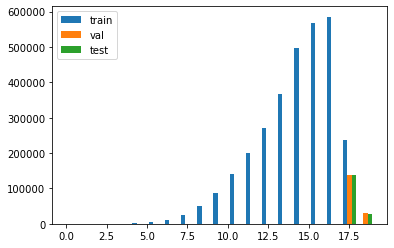

In [48]:
plt.figure()
max_len = max([len(idx) for idx in num_atoms_split.values()])
arr = []
for idx in num_atoms_split.values():
    this_arr = np.nan + np.zeros(max_len)
    this_arr[:len(idx)] = np.array(num_atoms)[idx]
    arr.append(this_arr)
arr = np.stack(arr, axis=1)

plt.hist(arr, stacked=False, bins=np.arange(0, np.nanmax(arr)), log=False)
plt.legend(num_atoms_split.keys())

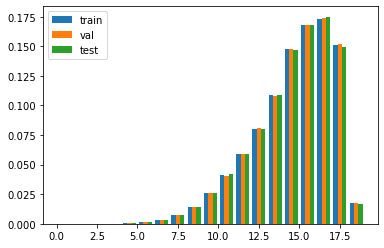

In [50]:
plt.figure()
max_len = max([len(idx) for idx in shuffle_split.values()])
arr = []
for idx in shuffle_split.values():
    this_arr = np.nan + np.zeros(max_len)
    this_arr[:len(idx)] = np.array(num_atoms)[idx]
    arr.append(this_arr)
arr = np.stack(arr, axis=1)

plt.hist(arr, stacked=False, bins=np.arange(0, np.nanmax(arr)), log=False, density=True)
plt.legend(shuffle_split.keys())